In [1]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import datetime
import xgboost as xgb
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier, early_stopping as lgb_early_stopping
#from catboost import CatBoostClassifier
from datetime import datetime
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, classification_report
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns
import toad
from toad.plot import bin_plot
from toad.metrics import KS, AUC
from scipy.stats import ks_2samp
import openpyxl

_______________________________________________________________________

In [2]:
datalogvalid = pd.read_csv('datalogvalid.csv')

In [3]:
datalogvalid

,Unnamed: 0,NPL91_EVER,gender_nameRu,LastApprovedOfferSet_Payment,CBFactPmtsParametrSet,AgeParametrSet,PoVClient_ClientCountWithoutOverduePay,CBMaxOverdueParametrSet,CBCreditHistoryFromServParametrSet,PKB_REQ_360DAY,SUM_OSTATOK,MAX_OUSTAND_DAY_CNT,CNT_DAY_GR_0_Sum,educationtypedmparse2,low_rod_income,KDN
0,21798,0,Мужской,16134.9,33,67.50,44.0,2,Приемлемая 1,3.0,234663.97,0.0,0.0,NaN,43407.0,0.163222
1,21800,0,Женский,56992.9,89,62.08,162.0,0,Положительная,2.0,230000.00,11.0,2.0,ВЫСШЕЕ,NaN,0.082131
2,21806,0,Женский,NaN,92,63.33,NaN,0,Положительная,0.0,154825.44,0.0,0.0,ВЫСШЕЕ,NaN,0.159070
3,21812,0,Женский,33750.0,82,66.67,13.0,3,Положительная,2.0,72800.00,32.0,5.0,ВЫСШЕЕ,NaN,0.000000
4,21815,0,Женский,76046.7,57,62.00,NaN,0,Приемлемая 2,2.0,NaN,0.0,0.0,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21379,224637,0,Женский,27284.6,156,61.42,85.0,2,Положительная,12.0,1710679.60,274.0,2.0,NaN,43407.0,0.451686
21380,224638,0,Мужской,NaN,44,67.92,13.0,0,Положительная,1.0,0.00,0.0,0.0,ВЫСШЕЕ,43407.0,0.000000
21381,224642,0,Женский,19448.8,4,68.42,38.0,0,Приемлемая 1,1.0,143759.68,0.0,0.0,NaN,43407.0,0.144615
21382,224646,0,Мужской,7732.7,23,66.42,30.0,0,Приемлемая 1,0.0,996339.01,18.0,2.0,НЕПОЛНОЕ СРЕДНЕЕ,43407.0,0.448766


In [4]:
#разделение датасета на трейн и тест
X_1 = datalogvalid.drop('NPL91_EVER', axis = 1)
y_1 = datalogvalid['NPL91_EVER']


In [5]:
import pickle

with open(f'BZK_Pension_validation_additional_files\pension_combiner_lr_2025.pkl', 'rb') as f:
	combiner1 = pickle.load(f)


In [6]:
X_selected_bin1 = combiner1.transform(X_1)


In [7]:
X_1.columns

Index(['Unnamed: 0', 'gender_nameRu', 'LastApprovedOfferSet_Payment',
       'CBFactPmtsParametrSet', 'AgeParametrSet',
       'PoVClient_ClientCountWithoutOverduePay', 'CBMaxOverdueParametrSet',
       'CBCreditHistoryFromServParametrSet', 'PKB_REQ_360DAY', 'SUM_OSTATOK',
       'MAX_OUSTAND_DAY_CNT', 'CNT_DAY_GR_0_Sum', 'educationtypedmparse2',
       'low_rod_income', 'KDN'],
      dtype='object')

In [8]:
#Просмотр бинов в каждой переменной:
print("Bins for each feature:")
for feature in combiner1.export():
    print(f"{feature}:{combiner1.export()[feature]}")

Bins for each feature:
gender_nameRu:[['Женский'], ['Мужской']]
LastApprovedOfferSet_Payment:[5000.0, 30000.0, nan]
CBFactPmtsParametrSet:[13, 24, 40, 100]
AgeParametrSet:[58, 63, 68]
PoVClient_ClientCountWithoutOverduePay:[7.0, 30.0, 70.0, nan]
CBMaxOverdueParametrSet:[10]
CBCreditHistoryFromServParametrSet:[['Положительная'], ['Приемлемая 2', 'Приемлемая 1', 'Удовлетворительная'], ['Отрицательная']]
PKB_REQ_360DAY:[3.0, 8.0, 16.0, nan]
SUM_OSTATOK:[100000.0, 500000.0, nan]
MAX_OUSTAND_DAY_CNT:[12.0, 28.0, nan]
CNT_DAY_GR_0_Sum:[1.0, 4.0, 11.0, nan]
educationtypedmparse2:[['ВЫСШЕЕ', 'УЧЁНАЯ СТЕПЕНЬ'], ['СРЕДНЕЕ СПЕЦИАЛЬНОЕ'], ['nan', 'СРЕДНЕЕ', 'НЕПОЛНОЕ СРЕДНЕЕ']]
low_rod_income:[65000.0, nan]
KDN:[0.1, 0.4, nan]


In [9]:
with open(f'BZK_Pension_validation_additional_files\pension_woe_transformer_lr_2025.pkl', 'rb') as f:
	t1 = pickle.load(f)


In [10]:

#трансформация тестового датасета
test_woe1 = t1.transform(X_selected_bin1)

In [11]:
with open(f'BZK_Pension_validation_additional_files\pension_model_lr_2025.pkl', 'rb') as f:
	lr_model = pickle.load(f)

In [12]:
datalogvalid['NPL91_EVER'].value_counts()

NPL91_EVER
0    20843
1      541
Name: count, dtype: int64

In [13]:
lr_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,"{0: 0.03, 1: 0.97}"
,random_state,42
,solver,'sag'
,max_iter,300
,multi_class,'auto'


In [14]:
# Display the features used in the logistic regression model
print("Features used in the logistic regression model:")
print(lr_model.feature_names_in_)
print(f"\nNumber of features: {len(lr_model.feature_names_in_)}")

Features used in the logistic regression model:
['gender_nameRu' 'LastApprovedOfferSet_Payment' 'CBFactPmtsParametrSet'
 'AgeParametrSet' 'PoVClient_ClientCountWithoutOverduePay'
 'CBMaxOverdueParametrSet' 'CBCreditHistoryFromServParametrSet'
 'PKB_REQ_360DAY' 'SUM_OSTATOK' 'MAX_OUSTAND_DAY_CNT' 'CNT_DAY_GR_0_Sum'
 'educationtypedmparse2' 'low_rod_income' 'KDN']

Number of features: 14


In [15]:
541*100/20843

2.5955956436213596

In [16]:
# Drop the 'Unnamed: 0' column from test_woe1
test_woe1 = test_woe1.drop('Unnamed: 0', axis=1)

Validation Metrics:
AUC: 0.6865
GINI: 0.3729
KS: 0.2802
Accuracy: 0.6330
Precision: 0.0434
Recall: 0.6414
F1-Score: 0.0812


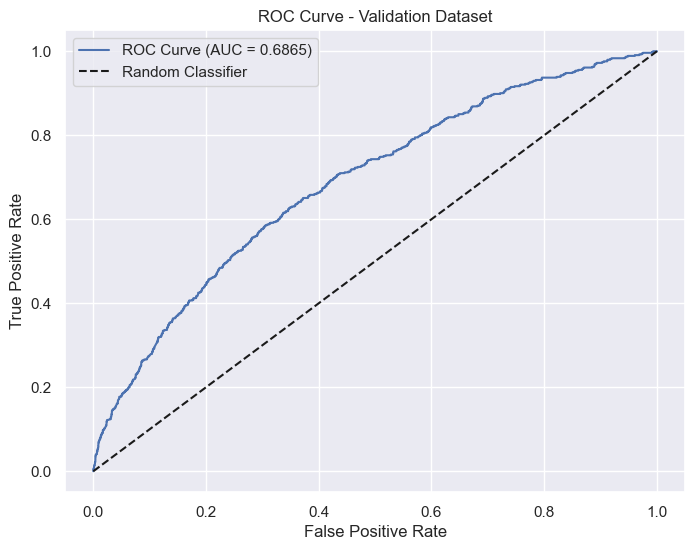

In [77]:
# Predict probabilities on validation dataset
y_pred_proba = lr_model.predict_proba(test_woe1)[:, 1]
y_pred_class = lr_model.predict(test_woe1)

# Calculate metrics
auc_score = roc_auc_score(y_1, y_pred_proba)
ks_score = KS(y_pred_proba, y_1)
accuracy = accuracy_score(y_1, y_pred_class)
precision = precision_score(y_1, y_pred_class)
recall = recall_score(y_1, y_pred_class)
f1 = f1_score(y_1, y_pred_class)

print(f"Validation Metrics:")
print(f"AUC: {auc_score:.4f}")
print(f"GINI: {2*auc_score-1:.4f}")
print(f"KS: {ks_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_1, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Dataset')
plt.legend()
plt.grid(True)
plt.show()

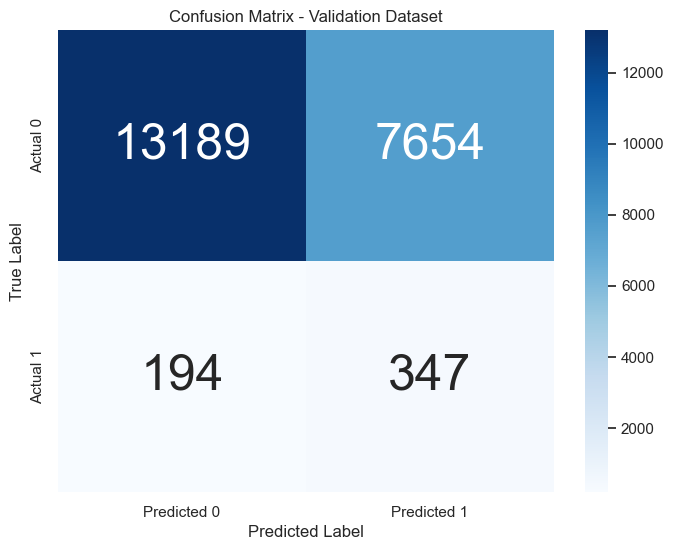

Confusion Matrix:
True Negatives (TN): 13189
False Positives (FP): 7654
False Negatives (FN): 194
True Positives (TP): 347


In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Draw confusion matrix

# Calculate confusion matrix
cm = confusion_matrix(y_1, y_pred_class)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'], 
            annot_kws={"size": 36})

plt.title('Confusion Matrix - Validation Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

----------------------------------------------------------------------------------------------------------

In [19]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import datetime
import xgboost as xgb
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier, early_stopping as lgb_early_stopping
#from catboost import CatBoostClassifier
from datetime import datetime
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, classification_report
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns
import toad
from toad.plot import bin_plot
from toad.metrics import KS, AUC
from scipy.stats import ks_2samp
import openpyxl

In [20]:
import pandas as pd

In [46]:
dataensvalid = pd.read_csv('dataensvalid.csv')

In [47]:
dataensvalid

,Unnamed: 0,NPL91_EVER,CNT_DEPOSIT,AMOUNT_REPLENISH_DEPO,AMOUNT_WITHDRAWAL_DEPO,CNT_LOAN_ONLINE,MONTH_LOAN_PAY_AMOUNT,AMOUNT_OUT_MONEY,AMOUNT_SOC_PAYOUT,AMOUNT_PENSION,...,deposit_cnt,deposit_amount,trans_in_pens_count_90d,trans_in_final_income,trans_out_cash_days_since_last_30d,trans_out_cash_amount_avg_90d,trans_out_cash_count_90d,trans_out_cash_days_since_last_90d,trans_out_p2p_months_active_90d,trans_out_qr_months_active_90d
0,21798,0,NaN,NaN,NaN,0.0,34523.87,NaN,0.0,103761.00,...,0.0,0.0,3.0,97217.000000,19.0,194000.0,2.0,48.0,1.0,0.0
1,21800,0,1.0,19.66,0.0,0.0,43548.10,NaN,0.0,186009.14,...,1.0,1690.0,6.0,172282.000000,2.0,20000.0,1.0,63.0,3.0,0.0
2,21806,0,NaN,NaN,NaN,0.0,24310.95,NaN,0.0,134400.90,...,0.0,0.0,6.0,124510.000000,25.0,379000.0,3.0,25.0,0.0,0.0
3,21812,0,NaN,NaN,NaN,1.0,18767.04,NaN,0.0,118112.67,...,0.0,0.0,3.0,91060.000000,26.0,293000.0,3.0,26.0,0.0,0.0
4,21815,0,NaN,NaN,NaN,1.0,11183.05,NaN,2769.0,172426.90,...,0.0,0.0,4.0,133713.000000,27.0,332000.0,4.0,27.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21379,224637,0,NaN,NaN,NaN,2.0,43665.80,NaN,0.0,178343.90,...,0.0,0.0,7.0,159228.000000,16.0,681000.0,12.0,16.0,3.0,1.0
21380,224638,0,NaN,NaN,NaN,NaN,NaN,150.0,0.0,193869.90,...,0.0,0.0,6.0,NaN,23.0,213000.0,2.0,54.0,1.0,0.0
21381,224642,0,0.0,NaN,NaN,0.0,32864.33,NaN,0.0,143203.00,...,1.0,1795.0,3.0,132310.000000,13.0,433000.0,8.0,13.0,0.0,0.0
21382,224646,0,NaN,NaN,NaN,1.0,76094.06,150.0,0.0,164704.00,...,0.0,0.0,3.0,152331.000000,8.0,231000.0,6.0,8.0,0.0,0.0


In [48]:
#заменяю inf и -inf средним значением:
def replace_inf_with_mean(df):
    float64_columns = df.select_dtypes(include = ['float64']).columns
    for col in float64_columns:
        df[col].replace([np.inf, -np.inf], 0, inplace = True)

replace_inf_with_mean(dataensvalid)

#заменяю пустые значения
def replace_na(df):
    for col in df.columns:
        if df[col].dtype != 'object':
            if df[col].isnull().any():
                df[col].fillna(0, inplace = True)
        elif df[col].dtype == 'object':
            if df[col].isnull().any():
                df[col].fillna('None', inplace = True)

replace_na(dataensvalid)

In [49]:


#Выделяю зависимую переменную
X = dataensvalid.drop('NPL91_EVER', axis = 1)
y = dataensvalid['NPL91_EVER']
#Разделяю датасет без зависимой переменной на числовые и нечисловые переменные: 
numeric_df = X.select_dtypes(include=[np.number])
object_df = X.select_dtypes(include=[object])

numeric_df = numeric_df.reset_index(drop=True)

object_df = object_df.reset_index(drop=True)
object_df = object_df.astype(str)
#Кодирую категориальные столбцы
label_encoders = {}
for column in object_df.columns:
    le = LabelEncoder()
    object_df[column] = le.fit_transform(object_df[column])
    label_encoders[column] = le
#Масштабирую числовые столбцы
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)
#Объедяю масштабированные числовые столбцы и закодированные категориальные столбцы
final_X = pd.concat([scaled_numeric_df, object_df], axis=1)

In [25]:
import pickle

In [50]:
with open(f'BZK_Pension_validation_additional_files\pension_combinerens_2025.pkl', 'rb') as f:
	combinerens = pickle.load(f)

In [51]:
train_selected_binens = combinerens.transform(final_X)

In [52]:
with open(f'BZK_Pension_validation_additional_files\pension_lgbm_model_2025.pkl', 'rb') as f:
	lgbm = pickle.load(f)
	
with open(f'BZK_Pension_validation_additional_files\pension_xgb_model_2025.pkl', 'rb') as f:
	xgb = pickle.load(f)  
	


In [53]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier()
catboost.load_model('BZK_Pension_validation_additional_files/pension_catboost_model_2025.cbm')

In [54]:
lgbm_top_features = lgbm.feature_name_
xgb_top_features = xgb.feature_names_in_
catboost_top_features = catboost.feature_names_

In [55]:
#Точность на тестовой выборке для каждой модели
lgbm_pred_class = lgbm.predict(train_selected_binens[lgbm_top_features])
xgb_pred_class = xgb.predict(train_selected_binens[xgb_top_features])
catboost_pred_class = catboost.predict(train_selected_binens[catboost_top_features])


In [56]:
# Calculate additional metrics for all models
lgbm_pred_proba = lgbm.predict_proba(train_selected_binens[lgbm_top_features])[:, 1]
xgb_pred_proba = xgb.predict_proba(train_selected_binens[xgb_top_features])[:, 1]
catboost_pred_proba = catboost.predict_proba(train_selected_binens[catboost_top_features])[:, 1]

# AUC scores
lgbm_auc = roc_auc_score(y, lgbm_pred_proba)
xgb_auc = roc_auc_score(y, xgb_pred_proba)
catboost_auc = roc_auc_score(y, catboost_pred_proba)

# KS scores
lgbm_ks = KS(lgbm_pred_proba, y)
xgb_ks = KS(xgb_pred_proba, y)
catboost_ks = KS(catboost_pred_proba, y)

print("\nDetailed Metrics:")
print("LightGBM:")
print(f"  AUC: {lgbm_auc:.4f}")
print(f"  GINI: {2*lgbm_auc-1:.4f}")
print(f"  KS: {lgbm_ks:.4f}")

print("XGBoost:")
print(f"  AUC: {xgb_auc:.4f}")
print(f"  GINI: {2*xgb_auc-1:.4f}")
print(f"  KS: {xgb_ks:.4f}")

print("CatBoost:")
print(f"  AUC: {catboost_auc:.4f}")
print(f"  GINI: {2*catboost_auc-1:.4f}")
print(f"  KS: {catboost_ks:.4f}")


Detailed Metrics:
LightGBM:
  AUC: 0.7303
  GINI: 0.4605
  KS: 0.3759
XGBoost:
  AUC: 0.5280
  GINI: 0.0560
  KS: 0.0647
CatBoost:
  AUC: 0.5875
  GINI: 0.1750
  KS: 0.1554


In [57]:
lgbm_weight = 0.40
xgb_weight = 0.21
catboost_weight = 0.39
print(f"Weights - LightGBM: {lgbm_weight:.2f}, XGBoost: {xgb_weight:.2f}, CatBoost: {catboost_weight:.2f}")

Weights - LightGBM: 0.40, XGBoost: 0.21, CatBoost: 0.39


In [ ]:
####Validation Ensemble with LR

In [58]:

def load_and_predict(new_data):
    lgbm_pred = lgbm.predict_proba(new_data[lgbm_top_features])[:, 1]
    xgb_pred = xgb.predict_proba(new_data[xgb_top_features])[:, 1]
    catboost_pred = catboost.predict_proba(new_data[catboost_top_features])[:, 1]
    #Объединение прогнозов
    stacked_probabilities = (lgbm_weight * lgbm_pred + xgb_weight * xgb_pred + catboost_weight * catboost_pred)
    return stacked_probabilities

#Получаем вероятности (probabilities of default, pd) 
stacked_probabilities_valid = load_and_predict(final_X)
#Преобразуем массив вероятностей в dataFrame для дальнейшего анализа
stacked_valid_df = pd.DataFrame(stacked_probabilities_valid)
#Задаём имя столбца с вероятностями дефолта
stacked_valid_df.columns = ['pd']

#Функция для категоризации вероятности дефолта (pd) по заданным диапазонам
def compute_pd(stacked_valid_df):    
    if 0 <= stacked_valid_df['pd'] <= 0.1:
        return '0-0.1'
    elif 0.1 < stacked_valid_df['pd'] <= 0.2:
        return '0.11-0.2'
    elif 0.2 < stacked_valid_df['pd'] <= 0.3:
        return '0.21-0.3'
    elif 0.3 < stacked_valid_df['pd'] <= 0.4:
        return '0.31-0.4'
    elif 0.4 < stacked_valid_df['pd'] <= 0.5:
        return '0.41-0.5'
    elif stacked_valid_df['pd'] > 0.5:
        return '>0.5'
    else:
        return '>0.5'
stacked_valid_df['pd_cat'] = stacked_valid_df.apply(compute_pd, axis = 1)
stacked_valid_df = stacked_valid_df.drop(['pd'], axis=1)

In [59]:
final_X

,Unnamed: 0,CNT_DEPOSIT,AMOUNT_REPLENISH_DEPO,AMOUNT_WITHDRAWAL_DEPO,CNT_LOAN_ONLINE,MONTH_LOAN_PAY_AMOUNT,AMOUNT_OUT_MONEY,AMOUNT_SOC_PAYOUT,AMOUNT_PENSION,AMOUNT_CASHIN_ATM,...,MOBILE_MODEL,MOBILE_BRAND,LAST_EVENT_COUNTRY,LAST_EVENT_CITY,SALARY_CATEGORY_BY_MODEL,TRANSACTION_CLIENT_SEGMENT,MCG_TOP1,MCG_TOP2,MCG_TOP3,FIRST_PRODUCT
0,-2.267256,-0.413690,-0.047347,-0.04028,-0.508469,-0.141645,-0.026462,-0.184646,-0.581086,-0.032216,...,120,107,10,53,10,13,15,14,4,1
1,-2.267216,1.694088,-0.047323,-0.04028,-0.508469,-0.014915,-0.026462,-0.184646,0.841142,-0.032216,...,156,142,6,14,6,14,15,25,4,1
2,-2.267098,-0.413690,-0.047347,-0.04028,-0.508469,-0.285069,-0.026462,-0.184646,-0.051263,-0.032216,...,120,107,10,53,10,3,15,14,11,1
3,-2.266980,-0.413690,-0.047347,-0.04028,0.095525,-0.362924,-0.026462,-0.184646,-0.332918,-0.032216,...,273,164,6,77,6,13,0,14,29,4
4,-2.266921,-0.413690,-0.047347,-0.04028,0.095525,-0.469429,-0.026462,-0.072845,0.606279,-0.032216,...,256,153,6,4,6,13,0,14,26,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21379,1.725270,-0.413690,-0.047347,-0.04028,0.699518,-0.013262,-0.026462,-0.184646,0.708595,-0.032216,...,227,153,6,4,6,13,0,25,33,1
21380,1.725289,-0.413690,-0.047347,-0.04028,-0.508469,-0.626477,-0.025505,-0.184646,0.977069,0.509692,...,120,115,6,96,6,13,15,14,4,6
21381,1.725368,-0.413690,-0.047347,-0.04028,-0.508469,-0.164951,-0.026462,-0.184646,0.100942,-0.032216,...,272,164,6,2,6,3,8,26,4,1
21382,1.725447,-0.413690,-0.047347,-0.04028,0.095525,0.442140,-0.025505,-0.184646,0.472735,-0.032216,...,274,164,6,96,6,13,0,14,29,4


In [66]:
#соединение train_woe с логистической регрессии с xgb_cat
#df1 = X_selected_bin1.reset_index(drop=True)

df1 = test_woe1.reset_index(drop=True)

df2 = stacked_valid_df.reset_index(drop=True)
val_bin_with = pd.concat([df1, df2], axis=1)

with open(f'BZK_Pension_validation_additional_files\pension_woe_transformerens_2025.pkl', 'rb') as f:
	t = pickle.load(f)

#трансформация тренировочного датасета
valid_woe_with = t.fit_transform(X=val_bin_with, y=y)

In [67]:
with open(f'BZK_Pension_validation_additional_files\pension_model_lrens_2025.pkl', 'rb') as f:
	lr1 = pickle.load(f)

In [68]:
features = lr1.feature_names_in_

In [69]:
features

array(['gender_nameRu', 'LastApprovedOfferSet_Payment',
       'CBFactPmtsParametrSet', 'AgeParametrSet',
       'PoVClient_ClientCountWithoutOverduePay',
       'CBMaxOverdueParametrSet', 'CBCreditHistoryFromServParametrSet',
       'PKB_REQ_360DAY', 'SUM_OSTATOK', 'MAX_OUSTAND_DAY_CNT',
       'CNT_DAY_GR_0_Sum', 'educationtypedmparse2', 'low_rod_income',
       'KDN', 'pd_cat'], dtype=object)

In [70]:
valid_woe_with[features]

,gender_nameRu,LastApprovedOfferSet_Payment,CBFactPmtsParametrSet,AgeParametrSet,PoVClient_ClientCountWithoutOverduePay,CBMaxOverdueParametrSet,CBCreditHistoryFromServParametrSet,PKB_REQ_360DAY,SUM_OSTATOK,MAX_OUSTAND_DAY_CNT,CNT_DAY_GR_0_Sum,educationtypedmparse2,low_rod_income,KDN,pd_cat
0,0.236702,-0.009715,0.213152,0.050544,-0.327855,-0.073778,0.603697,-0.144999,-0.085790,-0.233734,-0.262519,0.062532,0.033041,-0.121721,0.213813
1,-0.207987,-0.318938,-0.158304,-0.123433,-0.406787,-0.073778,-0.469280,-0.372881,-0.085790,-0.233734,-0.091593,-0.523277,0.010047,-0.134490,0.213813
2,-0.207987,0.076171,-0.158304,0.050544,0.301072,-0.073778,-0.469280,-0.372881,-0.085790,-0.233734,-0.262519,-0.523277,0.010047,-0.121721,-0.442402
3,-0.207987,-0.318938,-0.158304,0.050544,0.175485,-0.073778,-0.469280,-0.372881,-0.394924,0.465172,0.176238,-0.523277,0.010047,-0.134490,-0.442402
4,-0.207987,-0.318938,-0.158304,-0.123433,0.301072,-0.073778,0.603697,-0.372881,0.239211,-0.233734,-0.262519,0.062532,0.010047,-0.134490,-0.442402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21379,-0.207987,-0.009715,-0.409902,-0.123433,-0.406787,-0.073778,-0.469280,0.295914,0.126181,0.465172,-0.091593,0.062532,0.033041,0.247744,0.213813
21380,0.236702,0.076171,-0.158304,0.050544,0.175485,-0.073778,-0.469280,-0.372881,-0.394924,-0.233734,-0.262519,-0.523277,0.033041,-0.134490,0.213813
21381,-0.207987,-0.009715,0.723128,0.122014,-0.327855,-0.073778,0.603697,-0.372881,-0.085790,-0.233734,-0.262519,0.062532,0.033041,-0.121721,-0.442402
21382,0.236702,-0.009715,0.476212,0.050544,-0.327855,-0.073778,0.603697,-0.372881,0.126181,0.114388,-0.091593,0.062532,0.033041,0.247744,-0.442402


Validation Metrics:
AUC: 0.7113
GINI: 0.4226
KS: 0.3204
Accuracy: 0.8554
Precision: 0.0689
Recall: 0.3771
F1-Score: 0.1165


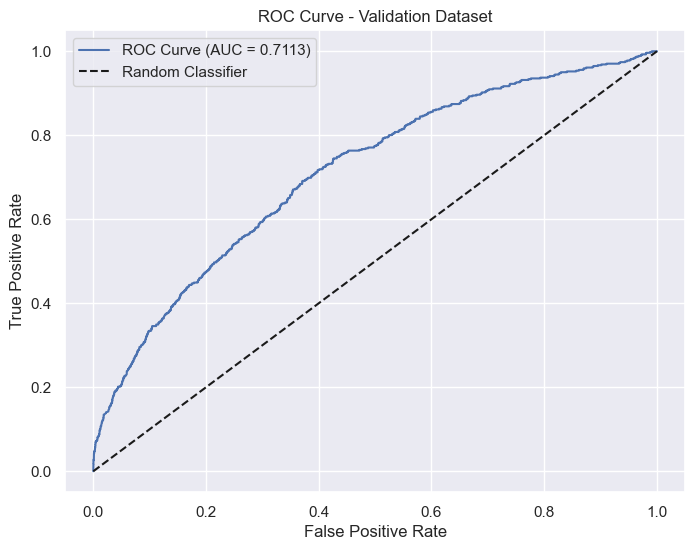

In [80]:
# Predict probabilities on validation dataset
y_pred_proba2 = lr1.predict_proba(valid_woe_with[features])[:, 1]
y_pred_class = lr1.predict(valid_woe_with[features])

# Calculate metrics
auc_score = roc_auc_score(y, y_pred_proba2)
ks_score = KS(y_pred_proba2, y)
accuracy = accuracy_score(y, y_pred_class)
precision = precision_score(y, y_pred_class)
recall = recall_score(y, y_pred_class)
f1 = f1_score(y, y_pred_class)

print(f"Validation Metrics:")
print(f"AUC: {auc_score:.4f}")
print(f"GINI: {2*auc_score-1:.4f}")
print(f"KS: {ks_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y, y_pred_proba2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Dataset')
plt.legend()
plt.grid(True)
plt.show()

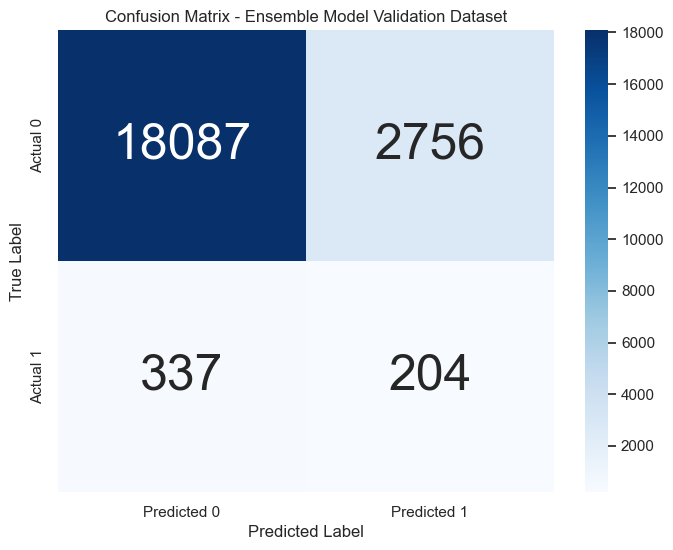

Confusion Matrix:
True Negatives (TN): 18087
False Positives (FP): 2756
False Negatives (FN): 337
True Positives (TP): 204


In [74]:
# Draw confusion matrix
cm = confusion_matrix(y, y_pred_class)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            annot_kws={"size": 36})  # Увеличиваем размер цифр в ячейках
plt.title('Confusion Matrix - Ensemble Model Validation Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

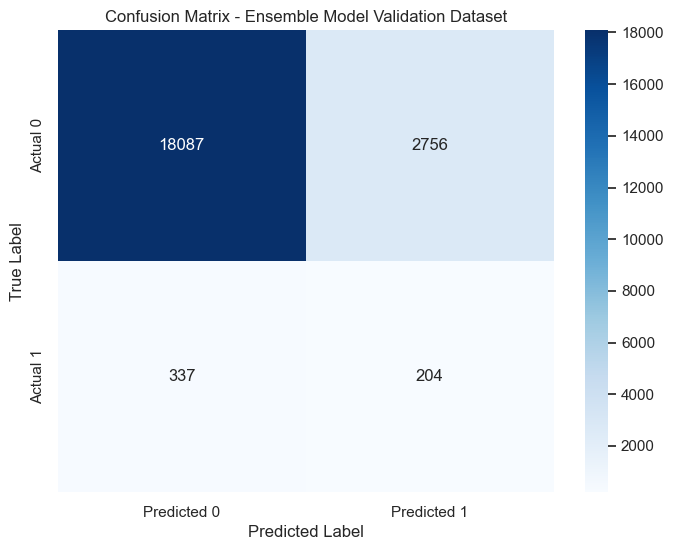

Confusion Matrix:
True Negatives (TN): 18087
False Positives (FP): 2756
False Negatives (FN): 337
True Positives (TP): 204


In [72]:
# Draw confusion matrix
cm = confusion_matrix(y, y_pred_class)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Ensemble Model Validation Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

In [ ]:
y_1

In [ ]:
import pandas as pd
import numpy as np

# Предполагаем, что у вас есть:
# y_val - реальные значения (0/1)
# y_pred_proba - предсказанные вероятности модели

def analyze_pd_distribution(y_true, y_pred_proba, n_bins=10, method='quantile'):
    """
    Анализ распределения PD по категориям
    
    Parameters:
    -----------
    y_true : array-like
        Реальные значения целевой переменной (0/1)
    y_pred_proba : array-like
        Предсказанные вероятности модели
    n_bins : int
        Количество категорий (по умолчанию 10 - децили)
    method : str
        'quantile' - равные группы по количеству
        'uniform' - равные интервалы по PD
    
    Returns:
    --------
    pd.DataFrame : таблица с анализом по категориям
    """
    
    df = pd.DataFrame({
        'true': y_true,
        'pred_proba': y_pred_proba
    })
    
    # Создаем категории
    if method == 'quantile':
        # Разбиваем на равные группы (децили/квинтили)
        df['category'] = pd.qcut(df['pred_proba'], q=n_bins, 
                                  labels=[f'Категория {i+1}' for i in range(n_bins)],
                                  duplicates='drop')
    else:
        # Разбиваем на равные интервалы
        df['category'] = pd.cut(df['pred_proba'], bins=n_bins,
                                labels=[f'Категория {i+1}' for i in range(n_bins)])
    
    # Группируем и считаем статистику
    result = df.groupby('category', observed=True).agg(
        Количество=('true', 'count'),
        Средний_предсказанный_PD=('pred_proba', 'mean'),
        Фактический_PD=('true', 'mean'),
        Количество_дефолтов=('true', 'sum')
    ).reset_index()
    
    # Добавляем границы PD для каждой категории
    bounds = df.groupby('category', observed=True)['pred_proba'].agg(['min', 'max']).reset_index()
    result = result.merge(bounds, on='category')
    
    # Добавляем разницу между предсказанным и фактическим
    result['Разница'] = result['Фактический_PD'] - result['Средний_предсказанный_PD']
    
    # Добавляем долю от общего числа клиентов
    result['Доля_клиентов_%'] = (result['Количество'] / result['Количество'].sum() * 100).round(1)
    
    # Форматируем проценты
    result['Средний_предсказанный_PD'] = (result['Средний_предсказанный_PD'] * 100).round(2)
    result['Фактический_PD'] = (result['Фактический_PD'] * 100).round(2)
    result['Разница'] = (result['Разница'] * 100).round(2)
    result['min'] = (result['min'] * 100).round(2)
    result['max'] = (result['max'] * 100).round(2)
    
    # Переименовываем колонки для читабельности
    result.columns = ['Категория', 'Кол-во клиентов', 'Средний PD (%)', 
                      'Фактический PD (%)', 'Кол-во дефолтов', 
                      'Мин PD (%)', 'Макс PD (%)', 'Разница (п.п.)', 'Доля клиентов (%)']
    
    return result


# ПРИМЕР ИСПОЛЬЗОВАНИЯ:

# Для Модели 1
pd_dist_model1 = analyze_pd_distribution(
    y_true=y_1,  # ваши реальные значения
    y_pred_proba=y_pred_proba,  # предсказания Модели 1
    n_bins=10,
    method='quantile'
)

print("=== Распределение PD для Модели 1 ===")
print(pd_dist_model1.to_string(index=False))

# Для Модели 2
pd_dist_model2 = analyze_pd_distribution(
    y_true=y,
    y_pred_proba=y_pred_proba2,  # предсказания Модели 2
    n_bins=10,
    method='quantile'
)

print("\n=== Распределение PD для Модели 2 ===")
print(pd_dist_model2.to_string(index=False))


# ВИЗУАЛИЗАЦИЯ (опционально)
import matplotlib.pyplot as plt

def plot_calibration(result_df, model_name):
    """График калибровки модели"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = range(len(result_df))
    
    ax.plot(x, result_df['Средний PD (%)'], marker='o', label='Предсказанный PD', linewidth=2)
    ax.plot(x, result_df['Фактический PD (%)'], marker='s', label='Фактический PD', linewidth=2)
    ax.plot(x, x, '--', color='gray', label='Идеальная калибровка', alpha=0.5)
    
    ax.set_xlabel('Категория риска', fontsize=12)
    ax.set_ylabel('PD (%)', fontsize=12)
    ax.set_title(f'Калибровка {model_name}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(result_df['Категория'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Построить графики
plot_calibration(pd_dist_model1, 'Модель 1 (Логрегрессия)')
plot_calibration(pd_dist_model2, 'Модель 2 (Логрегрессия + Ансамбль)')